## Sentimental Analysis

In [254]:
################## Codes For Testing ##################
# Printing first 5 rows
# hotel_reviews_df = hotel_reviews_df[["review", "cleaned_review"]]
# print(hotel_reviews_df.head()) 

# Uncomment the below two codes to get a smaller csv file (input the column that you wish to check)
# hotel_reviews_df = hotel_reviews_df[["review", "cleaned_review"]]
# hotel_reviews_df.to_csv('hotel_reviews_df_cleaned.csv', index=False)

In [3]:
#1. This step will add a new column called sentiments to classify the reviews based on four scores: 
# neutrality, positivity, negativity and overall scores that descrbies the previous three scores.
!pip install nltk
!pip install wordcloud
!pip install gensim
!pip install pandas
import nltk 
nltk.download('popular')
nltk.download('vader_lexicon')
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve

hotel_reviews_df_cleaned = pd.read_csv("hotel_reviews_df_cleaned.csv")

# IMPORTANT *** Extract out only this 3 columns because this is all what we need for ML
hotel_reviews_df_cleaned = hotel_reviews_df_cleaned[["review", "is_bad_review", "cleaned_review"]]

sid = SentimentIntensityAnalyzer()
hotel_reviews_df_cleaned["sentiments"] = hotel_reviews_df_cleaned["review"].apply(lambda review: sid.polarity_scores(str(review)))

hotel_reviews_df_cleaned = pd.concat([hotel_reviews_df_cleaned.drop(['sentiments'], axis=1), hotel_reviews_df_cleaned['sentiments'].apply(pd.Series)], axis=1)

hotel_reviews_df_cleaned.head()


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/alwin/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/alwin/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/alwin/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/alwin/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/alwin/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/alwin/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

,review,is_bad_review,cleaned_review,neg,neu,pos,compound
0,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924
1,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960
2,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908
3,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153
4,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717


In [4]:
#2. This will add 2 more new columns, the number of character and number of words column based on each corresponding review

hotel_reviews_df_cleaned["num_chars"] = hotel_reviews_df_cleaned["review"].apply(lambda x: len(str(x)))
hotel_reviews_df_cleaned["num_words"] = hotel_reviews_df_cleaned["review"].apply(lambda x: len(str(x).split(" ")))

hotel_reviews_df_cleaned.head()


,review,is_bad_review,cleaned_review,neg,neu,pos,compound,num_chars,num_words
0,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113
1,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10
2,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7
3,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27
4,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7


In [5]:
#3. Create doc2vec vector columns
# It is using the gensim library to create a Doc2Vec model and apply it to the cleaned review texts, 
# then concatenating the resulting vectors with the original DataFrame to create new columns.
# Doc2Vec is an unsupervised machine learning algorithm that learns fixed-length vector representations 
# (embeddings) from variable-length pieces of texts, such as documents, paragraphs, or sentences. 
# These embeddings can be used for tasks like text classification, clustering, and similarity matching. 
# Doc2Vec is an extension of Word2Vec, which learns embeddings for individual words. 
# Unlike Word2Vec, Doc2Vec learns a separate embedding for each document, while still taking into account 
# the words in the document.

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Create tagged documents
tagged_documents = [TaggedDocument(str(review).split(" "), [i]) for i, review in enumerate(hotel_reviews_df_cleaned["cleaned_review"])]
# tagged_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(hotel_reviews_df_cleaned["cleaned_review"].apply(lambda x: str(x).split(" ")))]
#Train the Doc2Vec model
model = Doc2Vec(tagged_documents, vector_size=5, window=2, min_count=1, workers=4)

#Infer vectors for each document
doc2vec_df = pd.DataFrame([model.infer_vector(str(review).split(" ")) for review in hotel_reviews_df_cleaned["cleaned_review"]])
doc2vec_df.columns = ["doc2vec_vector_" + str(i) for i in range(doc2vec_df.shape[1])]

# Concatenate the Doc2Vec vector with the original df
hotel_reviews_df_cleaned = pd.concat([hotel_reviews_df_cleaned, doc2vec_df], axis=1)

hotel_reviews_df_cleaned.head()


,review,is_bad_review,cleaned_review,neg,neu,pos,compound,num_chars,num_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.226884,0.426390,0.156518,0.370321,-0.481370
1,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.097973,0.119292,0.114242,-0.037324,-0.004816
2,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.008405,0.094775,0.019996,-0.028679,-0.009342
3,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,0.051696,0.263918,0.027675,0.039931,-0.078072
4,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,0.018296,0.026554,-0.027607,-0.050145,-0.072490


In [6]:
#4. Create TF-IDFS columns
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer with a minimum document frequency of 10
tfidf = TfidfVectorizer(min_df=10)

# # Fit the vectorizer to the cleaned reviews and transform the text into a matrix of TF-IDF features
hotel_reviews_df_cleaned["cleaned_review"] = hotel_reviews_df_cleaned["cleaned_review"].fillna("")
tfidf_result = tfidf.fit_transform(hotel_reviews_df_cleaned["cleaned_review"])


# # Convert the result to a pandas DataFrame with the feature names as column headers
tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns=tfidf.get_feature_names_out())

# # Add a prefix to each column name for identification purposes
tfidf_df = tfidf_df.add_prefix('word_')

# # Concatenate the original dataframe with the TF-IDF matrix
hotel_reviews_df_cleaned = pd.concat([hotel_reviews_df_cleaned, tfidf_df], axis=1)

In [7]:
hotel_reviews_df_cleaned.shape

(51574, 3840)

In [8]:
#5. Interested to find out the percentage of the dataset that is considered a bad review and good review
# This will help us see whether the dataset is balanced or imbalance, and further understand the skewness
total_Bad_Reviews = "is_bad_review"
results = hotel_reviews_df_cleaned[total_Bad_Reviews].value_counts()

#Get total reviews in the data set
#Query the bad reviews / total reviews * 100% to get percentage of bad reviews same for good reviews
totalReviews = results[0] + results[1]
goodReview = results[0]
badReview = results[1]
numOfBadReviews = badReview / totalReviews
print(round(numOfBadReviews, 3) * 100)

numOfGoodReviews = goodReview / totalReviews
print(round(numOfGoodReviews, 3) * 100)

print(results)


#From this we can see that the only 4.3% of the reviews given are bad and 95.7% are good.
#Dataset is not balanced but also can be used an indicator for client to know that they are doing a good job

4.3
95.7
0    49344
1     2230
Name: is_bad_review, dtype: int64


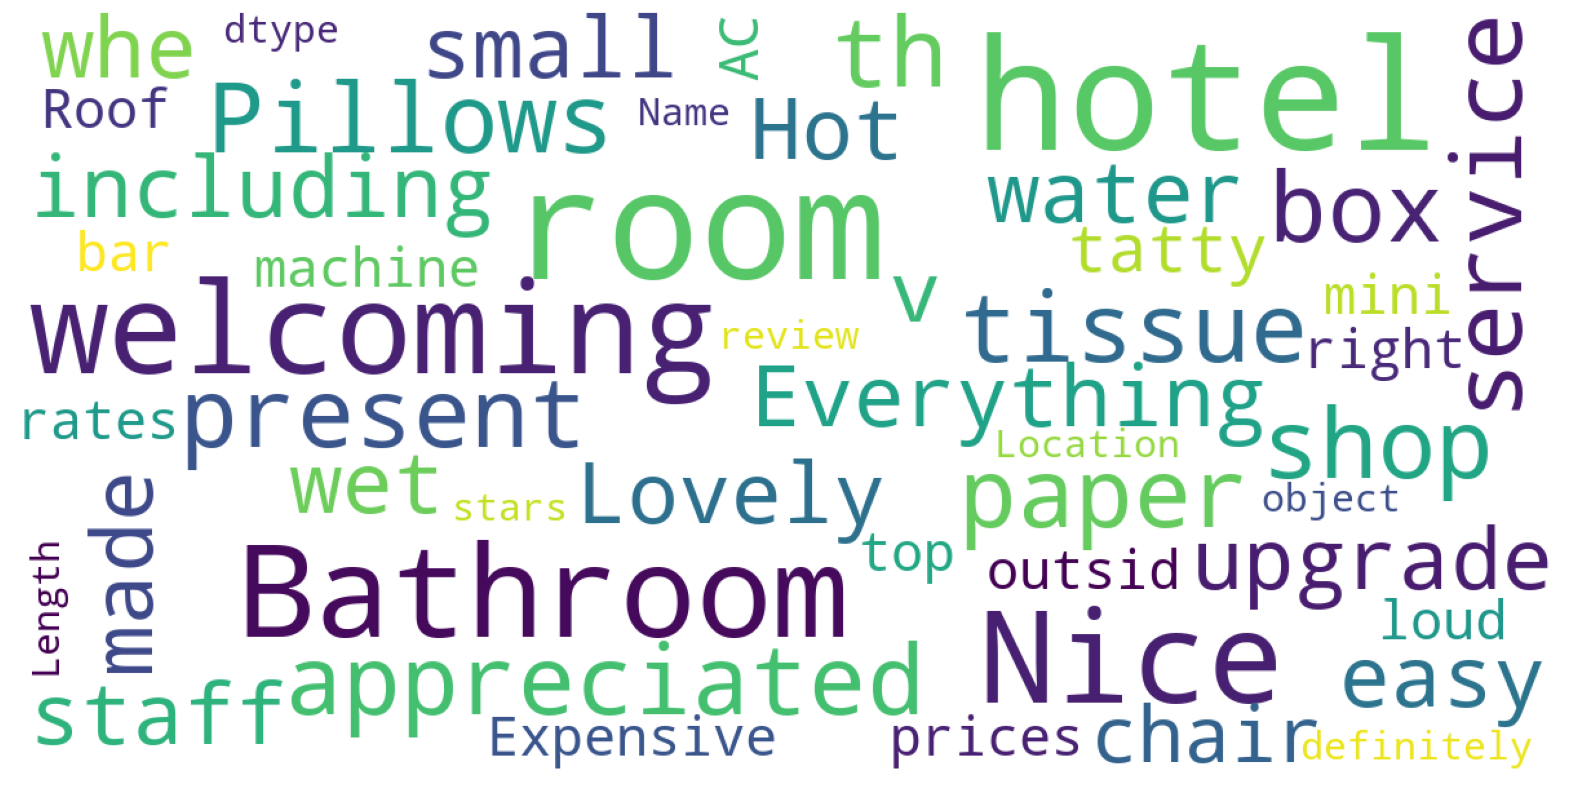

In [9]:
#6. Interested to find out the most used words in the reviews, regardless of good or bad
# This helps the client to see what is the sentiment about the hotel among previous guest
#Examples are "Expensive" which could indicate the per night prices are too high and or
#Small, which could indicate the rooms are too small. 
#Further investigation would be needed

def generateWordCloud(data, title = None):
    
    interestedData = str(data)
    
    wordCloud = WordCloud(
        background_color = 'white',
        max_words = 400,
        max_font_size = 40, 
        scale = 3, 
        random_state = 42
    ).generate(interestedData)

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')

    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordCloud)
    plt.show()


criteria = "review"
allHotelData = hotel_reviews_df_cleaned[criteria]
generateWordCloud(allHotelData)


In [10]:
#7. Get the first 10 highest reviews with a positive Sentiment
totalNumOfWords = hotel_reviews_df_cleaned["num_words"] 
totalNumOfWordsAboveFive = totalNumOfWords >= 5

getTotalNumOfWordsAboveFive = hotel_reviews_df_cleaned[totalNumOfWordsAboveFive]
getSortedPositiveValue = getTotalNumOfWordsAboveFive.sort_values("pos", ascending = False)[["review", "pos"]].head(10)
print(getSortedPositiveValue)

                                            review    pos
25597   A perfect location comfortable great value  0.931
46903               Clean comfortable lovely staff  0.907
868              Friendly welcome Comfortable room  0.905
48981                    Good location great value  0.904
22572               Clean friendly and comfortable  0.902
36916                  Good value amazing location  0.901
26382            breakfast excellent Clean comfort  0.899
21673                       Great place I enjoyed   0.881
46001                Beautiful Quirky Comfortable   0.878
27003                    Lovely comfortable rooms   0.877


In [11]:
#8. Get the first 10 highest reviews with a Negative Sentiment
totalNumOfWords = hotel_reviews_df_cleaned["num_words"]
totalNumOfWordsAboveFive = totalNumOfWords >= 5

getTotalNumOfWordsAboveFive = hotel_reviews_df_cleaned[totalNumOfWordsAboveFive]
getSortedPositiveValue = getTotalNumOfWordsAboveFive.sort_values("neg", ascending = False)[["review", "neg"]].head(10)
print(getSortedPositiveValue)

                                          review    neg
4592                       No dislikes LOCATION   0.831
9782     Nothing  Great helpful wonderful staff   0.812
32377                        A disaster  Nothing  0.804
21433   Nothing Excellent friendly helpful staff  0.799
15662                             A bit noisy No  0.796
1059                      Dirty hotel Smells bad  0.762
38524                        Very bad service No  0.758
3719                           Nothing  perfect   0.750
51441                    Window blind was broken  0.744
6724                Nothing Super friendly staff  0.743


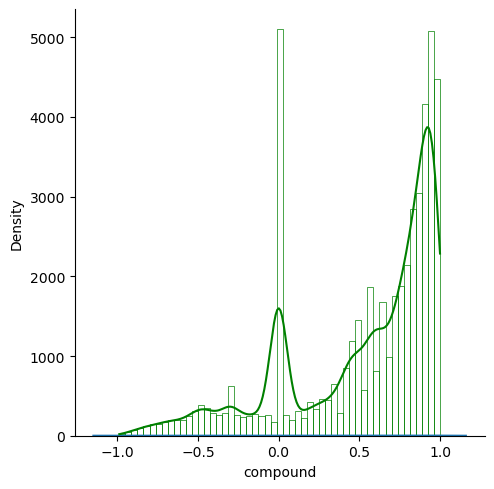

In [67]:
# To show good reviews only
for label, is_good_review in [("Good reviews", 0)]:
    reviewToPlot = is_good_review
    goodReview = hotel_reviews_df_cleaned['is_bad_review'] == reviewToPlot
    group = hotel_reviews_df_cleaned[goodReview]
    
    sns.displot(group['compound'], label = label, kind = "kde")
    sns.histplot(group['compound'], label = label, kde = True, color = "green", fill = False)
    
    

    


    

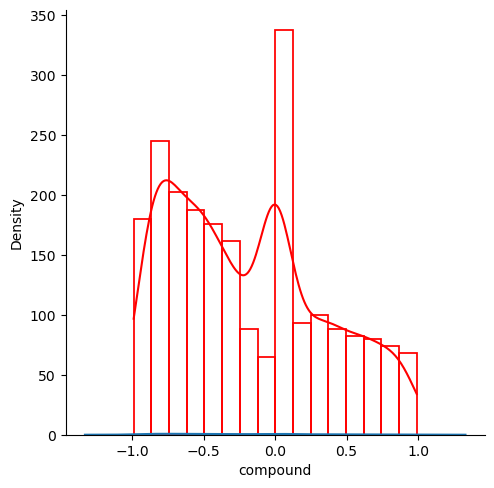

In [68]:
# To show Bad reviews only
for label, is_bad_review in [("Bad reviews", 1)]:
    reviewToPlot = is_bad_review
    badReview = hotel_reviews_df_cleaned['is_bad_review'] == reviewToPlot
    group = hotel_reviews_df_cleaned[badReview]
    
    sns.displot(group['compound'], label = label, kind = "kde")
    sns.histplot(group['compound'], label = label, kde = True, color = "red", fill = False)

/Users/alwin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='compound', ylabel='Density'>

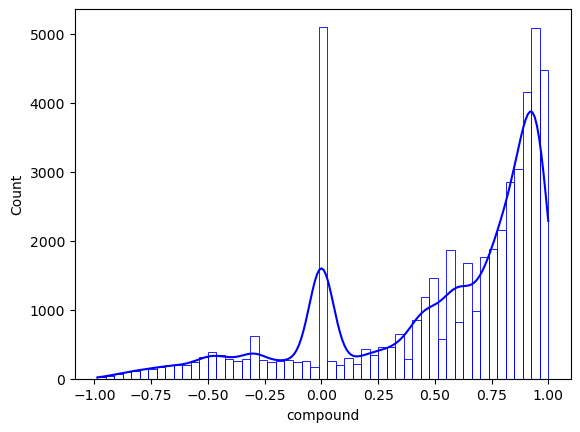

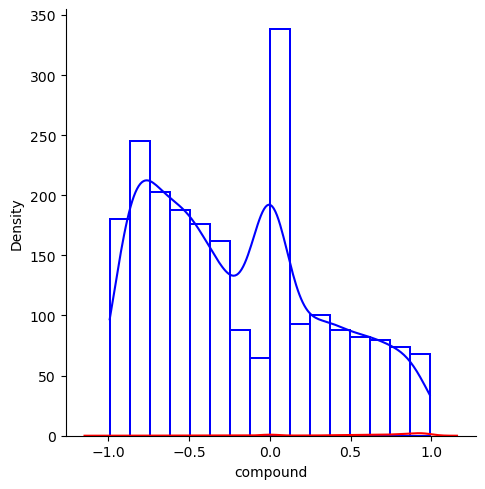

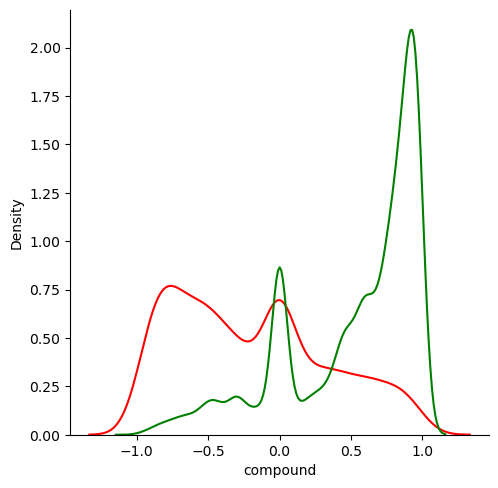

In [115]:
#9. Plot sentiment distribution for positive and negative reviews (To show bad reviews)
for label, is_bad_review in [("Good reviews", 0), ("Bad reviews", 1)]:
    reviewToPlot = is_bad_review
    badReview = hotel_reviews_df_cleaned['is_bad_review'] == reviewToPlot
    group = hotel_reviews_df_cleaned[badReview]
    
    sns.histplot(group['compound'], kde = True, label = label, color = "blue", fill = False)
    sns.displot(group['compound'], label = label, kind = "kde", color = "red", fill = False)
    
for label, is_bad_review in [("Good reviews", 0)]:
    reviewToPlot = is_bad_review
    badReview = hotel_reviews_df_cleaned['is_bad_review'] == reviewToPlot
    group = hotel_reviews_df_cleaned[badReview]
    
sns.distplot(group['compound'], hist = False, label = label,  color = "green")


In [128]:
#10. Modeling Reviewer Score

# Feature selection
label = "is_bad_review"
ignore = [label, "review", "cleaned_review"]

trainingData = [i for i in hotel_reviews_df_cleaned.columns if i not in ignore]

# split the data into train and test
trainX, testX, trainY, testY = train_test_split(hotel_reviews_df_cleaned[trainingData],
                                                    hotel_reviews_df_cleaned[label], 
                                                    test_size = 0.20, random_state = 42)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ea4e772d-4daa-4712-9df2-11ccbdb38015' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [129]:
#11. Train a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(trainX, trainY)

#12. Show feature importance
importances = pd.DataFrame({"Training Data": trainingData, "Importance Score": rf.feature_importances_}).sort_values("Importance Score", ascending = False)
importances.head(30)

,Training Data,Importance Score
3,compound,0.036071
2,pos,0.025848
0,neg,0.021888
6,doc2vec_vector_0,0.021779
10,doc2vec_vector_4,0.019742
8,doc2vec_vector_2,0.018913
4,num_chars,0.017102
9,doc2vec_vector_3,0.016387
7,doc2vec_vector_1,0.016269
1,neu,0.014593


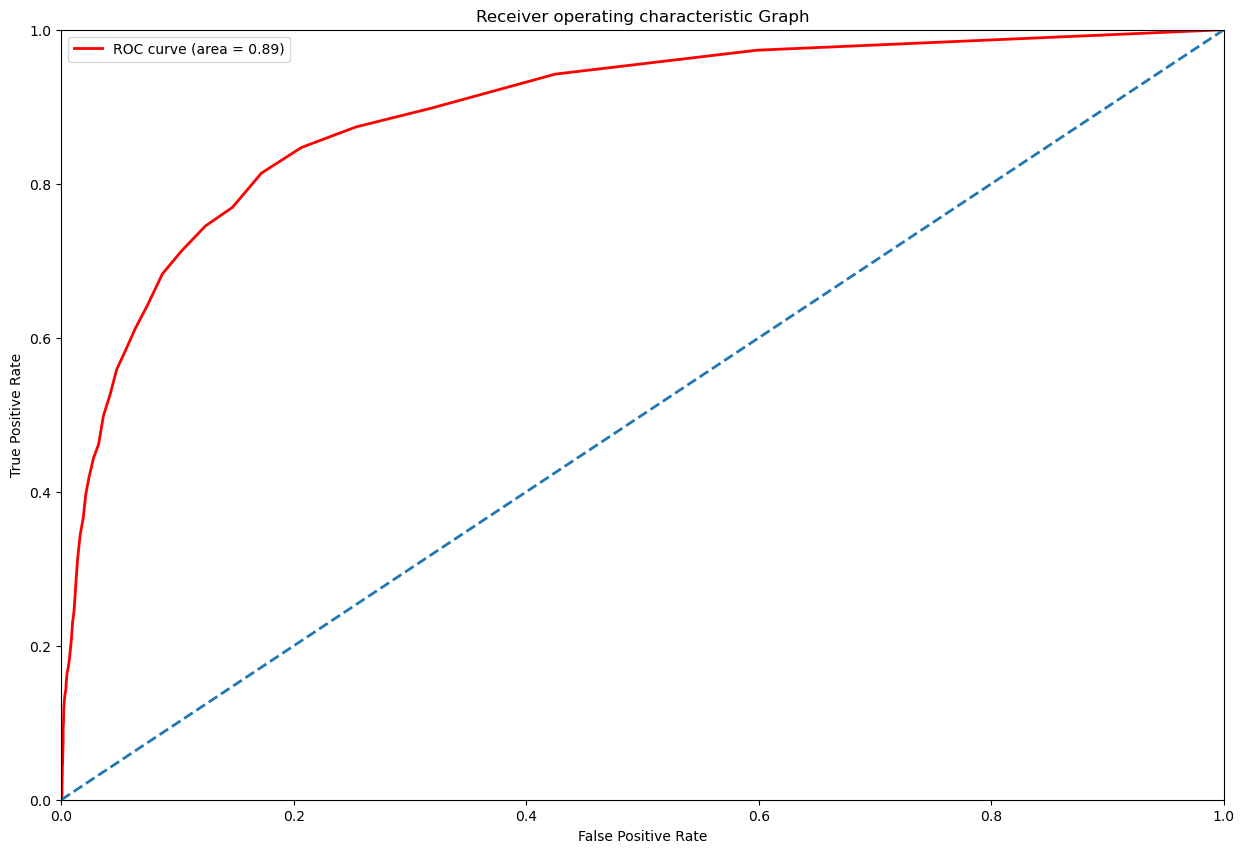

In [138]:
#13. ROC Curve

probY = rfc.predict_proba(testX)
predY = probY[:, 1]
falsePositiveRate, truePositiveRate, thresholds = roc_curve(testY, predY, pos_label = 1)

rocAreaUnderCurve = roc_auc_score(testY, predY)

plt.figure(figsize=(15, 10))
lw = 2
plt.plot(falsePositiveRate, 
         truePositiveRate, 
         color = 'red',
         lw = lw, 
         label ='ROC curve (area = %0.2f)' % rocAreaUnderCurve)

plt.plot([0, 1], 
         [0, 1], 
         lw = lw, 
         linestyle ='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc = "upper left")
plt.show()

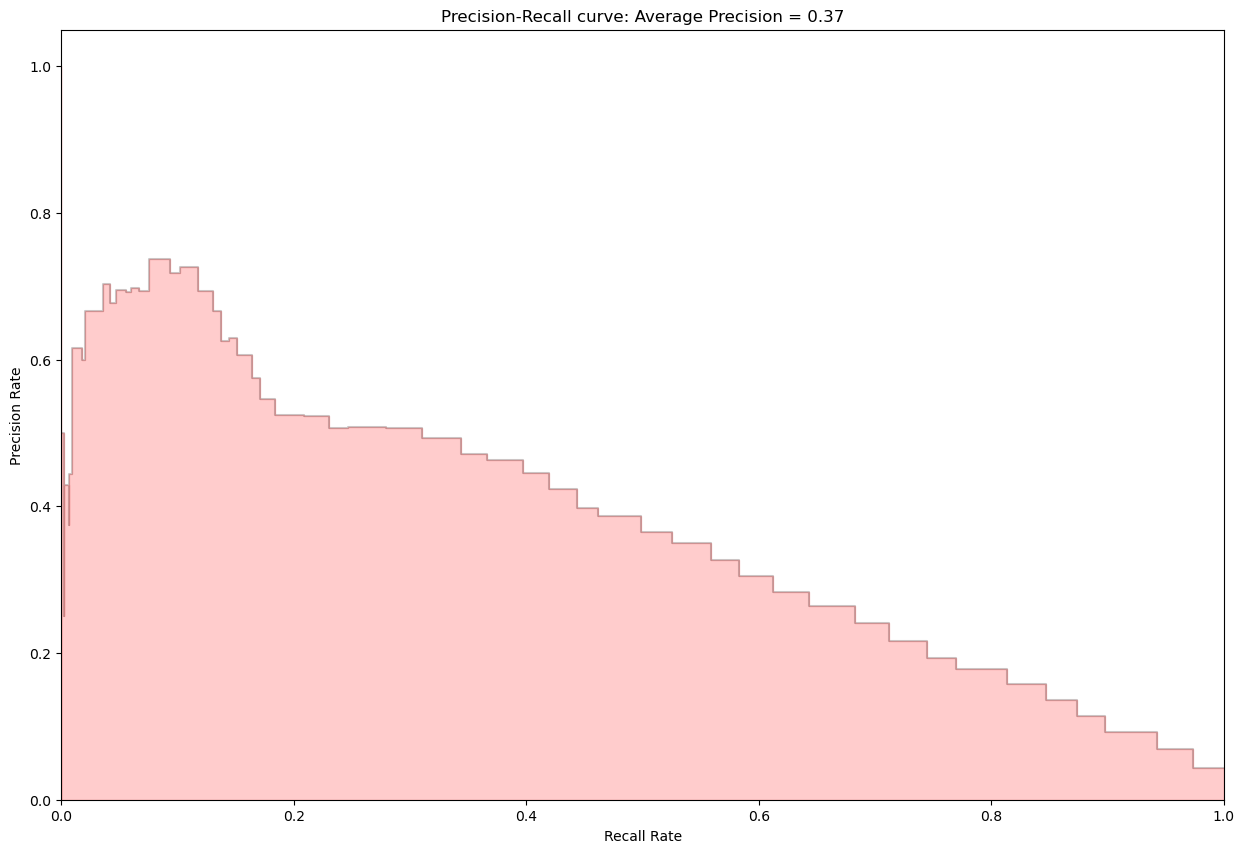

In [151]:
#14. Precision-Recall curve

averagePrecision = average_precision_score(testY, predY)

precision, recall, _ = precision_recall_curve(testY, predY)

plt.figure(1, 
           figsize=(15, 10))

plt.step(recall, 
         precision, 
         color ='black', 
         alpha = 0.2, 
         where ='post')

plt.fill_between(recall, 
                 precision, 
                 alpha = 0.2, 
                 color ='red', 
                 step ='post')

plt.xlabel('Recall Rate')
plt.ylabel('Precision Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(averagePrecision))
plt.show()